In [6]:
import os
import tensorflow as tf
import random
import numpy as np
import cv2
import gc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import recall_score

# Enable mixed precision for better performance on GPU
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load a random selection of 100 images from each directory
def load_random_images_from_directories(directories, num_images_per_class=100):
    images = []
    labels = []
    image_paths = []

    for i, directory in enumerate(directories):
        image_list = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.jpg')]
        random.shuffle(image_list)
        selected_images = image_list[:num_images_per_class]
        
        for path in selected_images:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))  # Resize to match input shape
            img = img / 255.0  # Normalize to [0, 1]
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            images.append(img)
            labels.append(i)  # Label based on directory (0: normal, 1-3: misbehavior)
            image_paths.append(path)

    return np.array(images), np.array(labels), image_paths

# Directories for normal and misbehavior images
normal_dir = '/home/UFAD/vivaangoomer/Downloads/data_perfect_driving 3/data_perfect_driving/images'
blurry_dir = '/home/UFAD/vivaangoomer/Downloads/data_perfect_driving 3/data_perfect_driving/images_blurred'
dirt_dir = '/home/UFAD/vivaangoomer/Downloads/data_perfect_driving 3/data_perfect_driving/images_dirt/'
tape_dir = '/home/UFAD/vivaangoomer/Downloads/data_perfect_driving 3/data_perfect_driving/images_tape/'

# List of directories to load images from
directories = [blurry_dir, dirt_dir, tape_dir]

# Load 100 random images from each directory
misbehavior_images, misbehavior_labels, misbehavior_paths = load_random_images_from_directories(directories)

# Load all normal images (if needed, you can limit it to 100 as well)
normal_images, normal_labels, normal_paths = load_random_images_from_directories([normal_dir], num_images_per_class=100)

# Combine the images and labels
images = np.concatenate((normal_images, misbehavior_images), axis=0)
labels = np.concatenate((normal_labels, misbehavior_labels), axis=0)
all_image_paths = normal_paths + misbehavior_paths

# Add noise to the images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noisy_images = add_noise(images)

# Define the denoising autoencoder model
def build_denoising_autoencoder(input_shape=(224, 224, 1)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Instantiate and compile the autoencoder model
autoencoder = build_denoising_autoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training parameters
epochs = 50
batch_size = 32

# Callbacks
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_denoising_autoencoder.keras', save_best_only=True, monitor='loss', verbose=1)

# Fit the model on the noisy and clean images
history = autoencoder.fit(
    noisy_images, images,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# Save the final model
autoencoder.save('denoising_autoencoder_model_final.keras')

# Calculate reconstruction errors and identify misbehavior images
reconstructed_images = autoencoder.predict(noisy_images)
reconstruction_errors = np.mean(np.square(images - reconstructed_images), axis=(1, 2, 3))

# Identify misbehavior images by high reconstruction error
sorted_indices = np.argsort(reconstruction_errors)[::-1]
top_100_indices = sorted_indices[:100]

# Check how many misbehavior images are in the top 100 high MSE images
num_misbehavior_in_top_100 = sum(1 for idx in top_100_indices if labels[idx] != 0)
print(f"Number of misbehavior images in the top 100 high MSE images: {num_misbehavior_in_top_100}")


Epoch 1/50
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 1: loss did not improve from inf
13/13 [==============================] - 5s 58ms/step - loss: nan - lr: 0.0010
Epoch 2/50
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 2: loss did not improve from inf
13/13 [==============================] - 1s 55ms/step - loss: nan - lr: 0.0010
Epoch 3/50
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 3: loss did not improve from inf
13/13 [==============================] - 1s 54ms/step - loss: nan - lr: 0.0010
Epoch 4/50
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 4: loss did not improve from inf
13/13 [==============================] - 1s 55ms/step - loss: nan - lr: 5.0000e-04
Epoch 5/50
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 5: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Number of misbehavior images in the top 100 high MSE images: 100


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_70 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 batch_normalization_60 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_61 (Ba  (None, 112, 112, 128)     512

Epoch 17/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 17: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 17, Recall: 0.4000
13/13 [==============================] - 1s 87ms/step - loss: nan - lr: 3.1250e-05
Epoch 18/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 18: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 18, Recall: 0.4000
13/13 [==============================] - 1s 86ms/step - loss: nan - lr: 3.1250e-05
Epoch 19/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 19: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 19, Recall: 0.4000
13/13 [==============================] - 1s 87ms/step - loss: nan - lr: 1.5625e-05
Epoch 20/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 20: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoc

Epoch 47/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 47: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 47, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 48/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 48: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 48, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 49/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 49: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 49, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 50/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 50: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoc

Epoch 77/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 77: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 77, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 78/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 78: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 78, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 79/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 79: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 79, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 80/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 80: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoc

Epoch 107/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 107: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 107, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 108/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 108: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 108, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 109/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 109: loss did not improve from inf
13/13 [==============================] - 0s 10ms/step
Epoch 109, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 110/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 110: loss did not improve from inf
13/13 [==============================] - 0s 11m

13/13 [==============================] - 0s 11ms/step
Epoch 136, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 137/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 137: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 137, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 138/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 138: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 138, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 139/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 139: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 139, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06


Epoch 166/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 166: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 166, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 167/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 167: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 167, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 168/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 168: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 168, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 169/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 169: loss did not improve from inf
13/13 [==============================] - 0s 11m

13/13 [==============================] - 0s 11ms/step
Epoch 195, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 196/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 196: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 196, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 197/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 197: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 197, Recall: 0.4000
13/13 [==============================] - 1s 94ms/step - loss: nan - lr: 1.0000e-06
Epoch 198/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 198: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 198, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06


Epoch 225/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 225: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 225, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 226/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 226: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 226, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 227/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 227: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 227, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 228/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 228: loss did not improve from inf
13/13 [==============================] - 0s 11m

13/13 [==============================] - 0s 11ms/step
Epoch 254, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 255/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 255: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 255, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06
Epoch 256/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 256: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 256, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 257/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 257: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 257, Recall: 0.4000
13/13 [==============================] - 1s 88ms/step - loss: nan - lr: 1.0000e-06


Epoch 284/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 284: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 284, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 285/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 285: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 285, Recall: 0.4000
13/13 [==============================] - 1s 93ms/step - loss: nan - lr: 1.0000e-06
Epoch 286/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 286: loss did not improve from inf
13/13 [==============================] - 0s 11ms/step
Epoch 286, Recall: 0.4000
13/13 [==============================] - 1s 89ms/step - loss: nan - lr: 1.0000e-06
Epoch 287/300
12/13 [==========================>...] - ETA: 0s - loss: nan
Epoch 287: loss did not improve from inf
13/13 [==============================] - 0s 11m

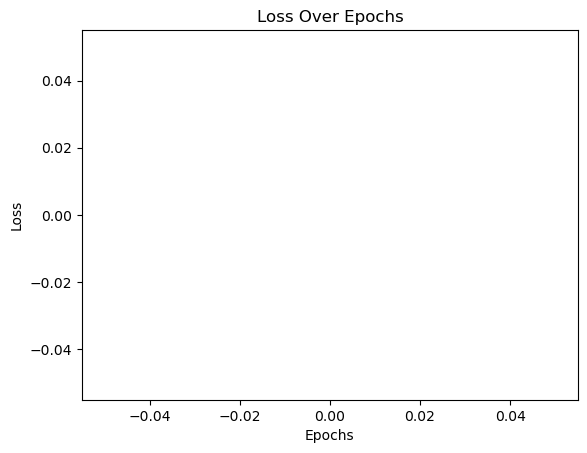

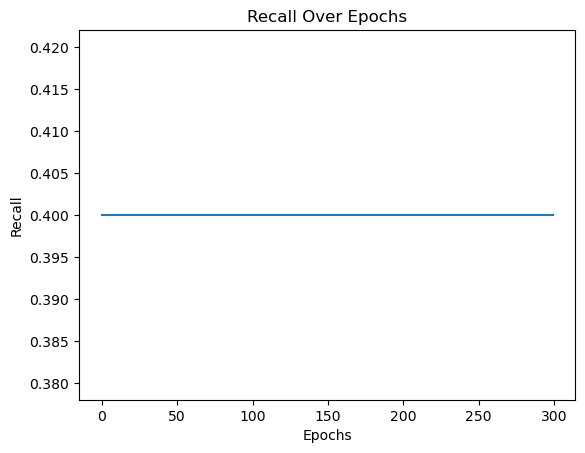

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

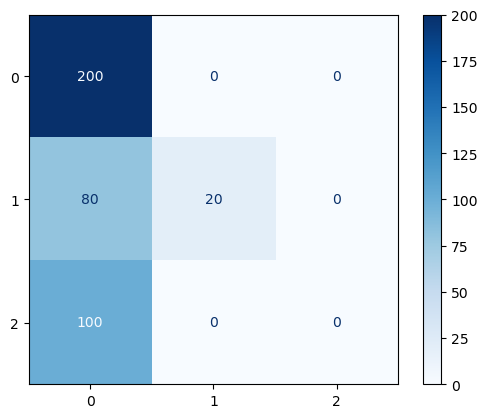

In [11]:
import os
import tensorflow as tf
import random
import numpy as np
import cv2
import gc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

# Enable mixed precision for better performance on GPU
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load a random selection of 100 images from each directory
def load_random_images_from_directories(directories, num_images_per_class=100):
    images = []
    labels = []
    image_paths = []

    for i, directory in enumerate(directories):
        image_list = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.jpg')]
        random.shuffle(image_list)
        selected_images = image_list[:num_images_per_class]
        
        for path in selected_images:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))  # Resize to match input shape
            img = img / 255.0  # Normalize to [0, 1]
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            images.append(img)
            labels.append(i)  # Label based on directory (0: normal, 1-3: misbehavior)
            image_paths.append(path)

    return np.array(images), np.array(labels), image_paths

# Directories for normal and misbehavior images
normal_dir = '/home/UFAD/vivaangoomer/Downloads/data_perfect_driving 3/data_perfect_driving/images'
blurry_dir = '/home/UFAD/vivaangoomer/Downloads/data_perfect_driving 3/data_perfect_driving/images_blurred'
dirt_dir = '/home/UFAD/vivaangoomer/Downloads/data_perfect_driving 3/data_perfect_driving/images_dirt/'
tape_dir = '/home/UFAD/vivaangoomer/Downloads/data_perfect_driving 3/data_perfect_driving/images_tape/'

# List of directories to load images from
directories = [blurry_dir, dirt_dir, tape_dir]

# Load 100 random images from each directory
misbehavior_images, misbehavior_labels, misbehavior_paths = load_random_images_from_directories(directories)

# Load all normal images (you can limit this if needed)
normal_images, normal_labels, normal_paths = load_random_images_from_directories([normal_dir], num_images_per_class=100)

# Combine the images and labels
images = np.concatenate((normal_images, misbehavior_images), axis=0)
labels = np.concatenate((normal_labels, misbehavior_labels), axis=0)
all_image_paths = normal_paths + misbehavior_paths

# Add noise to the images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noisy_images = add_noise(images)

# Define the denoising autoencoder model
def build_denoising_autoencoder(input_shape=(224, 224, 1)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

autoencoder = build_denoising_autoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')  # MSE loss for reconstruction

autoencoder.summary()

# Training parameters
epochs = 300
batch_size = 32

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_denoising_autoencoder.keras', save_best_only=True, monitor='loss', verbose=1)

class RecallHistory(tf.keras.callbacks.Callback):
    def __init__(self, model_input, model_target, true_labels):
        super(RecallHistory, self).__init__()
        self.recall_history = []
        self.loss_history = []
        self.model_input = model_input
        self.model_target = model_target
        self.true_labels = true_labels

    def on_epoch_end(self, epoch, logs=None):
        self.loss_history.append(logs["loss"])
        reconstructed_images = self.model.predict(self.model_input)
        reconstruction_errors = np.mean(np.square(self.model_target - reconstructed_images), axis=(1, 2, 3))
        threshold = np.percentile(reconstruction_errors, 95)
        predicted_labels = (reconstruction_errors > threshold).astype(int)
        
        # Use 'macro', 'micro', or 'weighted' averaging for multiclass recall
        recall = recall_score(self.true_labels, predicted_labels, average='macro')
        self.recall_history.append(recall)
        print(f'Epoch {epoch + 1}, Recall: {recall:.4f}')


# Initialize the RecallHistory callback with the required parameters
recall_history = RecallHistory(model_input=noisy_images, model_target=images, true_labels=labels)

# Fit model on the full dataset
history = autoencoder.fit(
    noisy_images, images,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint, reduce_lr, recall_history],
    verbose=1
)

# Save the final model
autoencoder.save('denoising_autoencoder_model_final.keras')

# Calculate reconstruction errors and identify misbehavior images
reconstructed_images = autoencoder.predict(noisy_images)
reconstruction_errors = np.mean(np.square(images - reconstructed_images), axis=(1, 2, 3))

# Identify misbehavior images by high reconstruction error (Top 1000)
sorted_indices = np.argsort(reconstruction_errors)[::-1]
top_1000_indices = sorted_indices[:1000]

# Check how many misbehavior images are in the top 1000 high MSE images
num_misbehavior_in_top_1000 = sum(1 for idx in top_1000_indices if labels[idx] != 0)
print(f"Number of misbehavior images in the top 1000 high MSE images: {num_misbehavior_in_top_1000}")

# Plot loss over epochs
plt.plot(recall_history.loss_history)
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot recall over epochs
plt.plot(recall_history.recall_history)
plt.title('Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.show()

# Confusion matrix for top 1000 MSE images
top_1000_labels = labels[top_1000_indices]
top_1000_predictions = (reconstruction_errors[top_1000_indices] > np.percentile(reconstruction_errors, 95)).astype(int)

conf_matrix = confusion_matrix(top_1000_labels, top_1000_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Misbehavior"])
disp.plot(cmap=plt.cm.Blues)
plt.show()
